In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.constants import elementary_charge

from nils.reconstruction_module import cleanup_formfactor
from nils.reconstruction_module_after_diss import master_recon
from nils.simulate_spectrometer_signal import get_crisp_signal


In [2]:
data_dir = Path("data/zihan")
data_filepath = data_dir / "data_20220905.pkl"
df = pd.read_pickle(data_filepath)


In [3]:
len(df)


32000

In [4]:
i = 0


In [5]:
df.loc[i, ["chirp", "curv", "skew", "chirpL1", "chirpL2"]]


chirp        -7.44
curv         281.3
skew       45442.0
chirpL1     -13.43
chirpL2       2.11
Name: 0, dtype: object

In [6]:
df.loc[i, "slice_width"]


3.026108006382898e-07

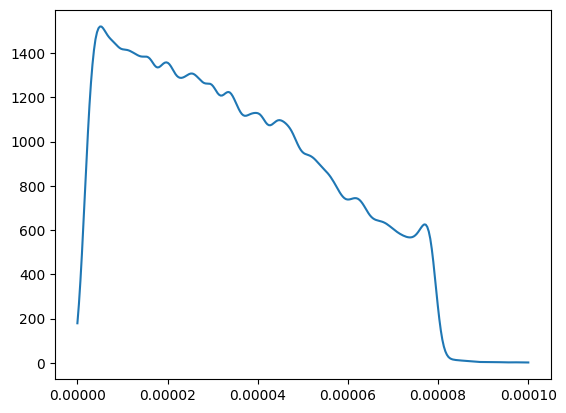

In [7]:
ss = np.linspace(i, 0.1e-3, num=300)  # * df.loc[0, "slice_width"]
currents = np.array(df.loc[i, "slice_I"])

plt.plot(ss, currents)
plt.show()


In [8]:
def current2formfactor(
    ss: np.ndarray,
    currents: np.ndarray,
    grating: str = "both",
    clean: bool = False,
    n_shots: int = 10,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Convert a currents `current` over `s` to it the corresponding cleaned formfactor
    produced by CRISP with `grating` active.
    """

    frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
        ss, currents, n_shots=n_shots, which_set=grating
    )

    if clean:
        frequencies, formfactor, _ = cleanup_formfactor(
            frequencies, formfactor, formfactor_noise, detlim, channels_to_remove=[]
        )

    return frequencies, formfactor


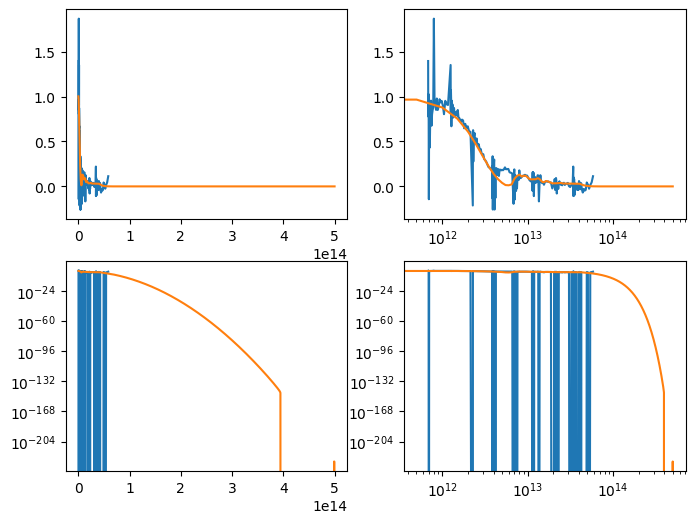

In [9]:
frequencies, formfactor = current2formfactor(
    ss, currents, grating="both", n_shots=1, clean=False
)
clean_frequencies, clean_formfactor = current2formfactor(
    ss, currents, grating="high", clean=True
)

plt.figure(figsize=(8, 6))
plt.subplot(221)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.subplot(222)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.subplot(223)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.yscale("log")
plt.subplot(224)
plt.plot(frequencies, formfactor)
plt.plot(clean_frequencies, clean_formfactor)
plt.xscale("log")
plt.yscale("log")
plt.show()


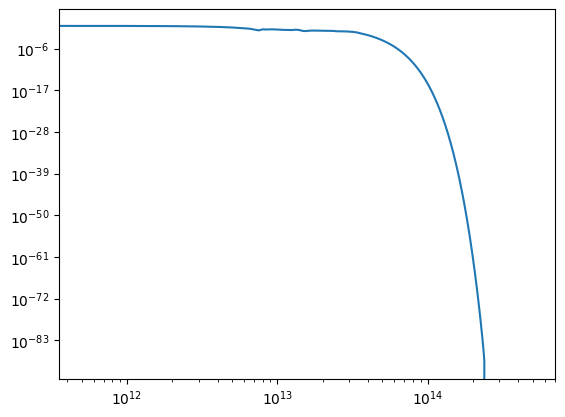

In [10]:
frequencies, formfactor = current2formfactor(ss, currents, grating="high", clean=True)

plt.plot(frequencies, formfactor)
plt.loglog()
plt.show()


0
1
Convergiert: 1


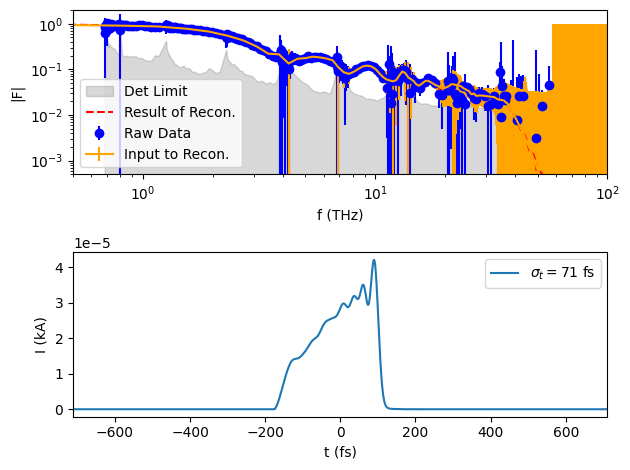

In [11]:
frequencies, formfactor, formfactor_noise, detlim = get_crisp_signal(
    ss, currents, n_shots=10, which_set="both"
)

reconstructed = master_recon(
    frequencies,
    formfactor,
    formfactor_noise,
    detlim,
    charge=40000 * elementary_charge,
)


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [23]:
rfs_dataset = df[["chirp", "chirpL1", "chirpL2", "curv", "skew"]].values

rfs_dataset.shape


(32000, 5)

In [32]:
ss_dataset = np.stack(
    [np.linspace(0, 300 * df.loc[i, "slice_width"], num=300) for i in df.index]
)
ss_dataset.shape


(32000, 300)

In [35]:
lengths = ss_dataset.max(axis=1) - ss_dataset.min()
lengths.shape


(32000,)

In [36]:
currents_dataset = np.stack(df["slice_I"].values)
currents_dataset.shape


(32000, 300)

In [37]:
stacked_currents_dataset = np.stack([ss_dataset, currents_dataset], axis=1)
stacked_currents_dataset.shape


(32000, 2, 300)

In [73]:
formfactors_dataset = np.array(
    [
        current2formfactor(ss, currents, grating="both", n_shots=1, clean=False)
        for ss, currents in zip(ss_dataset, currents_dataset)
    ]
)
formfactors_dataset.shape


(32000, 2, 240)

In [74]:
formfactors_dataset_reshaped = formfactors_dataset.reshape(-1, 480)
formfactors_dataset_reshaped.shape

(32000, 480)

In [75]:
X = np.concatenate([rfs_dataset, formfactors_dataset_reshaped], axis=1)
y = stacked_currents_dataset

X.shape, y.shape


((32000, 485), (32000, 2, 300))

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [89]:
knn = KNeighborsRegressor(n_neighbors=1).fit(X_train[:], y_train.reshape(-1, 600))


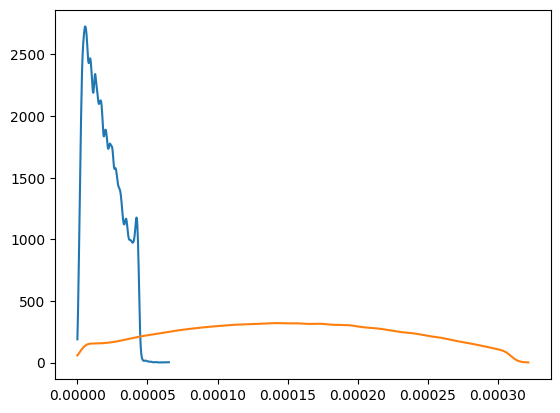

In [90]:
i = 42
pred = knn.predict(X_test[i:i+1])
ss, currents = pred.reshape(2, 300)

plt.plot(ss, currents)
plt.plot(y_test[i,0], y_test[i,1])
plt.show()